In [1]:
import pandas as pd
import numpy as np
from random import randint, choice
import seaborn as sns
from scipy.sparse import csgraph
import random
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def DTWDistance(s1, s2, data_format="pandas"):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            if data_format=="pandas":
                dist= (s1.iloc[i]-s2.iloc[j])**2
            else:
                dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [3]:
def put_weights_measure(graph, time_series, method=0, data_format="pandas"):
    new_graph = graph
    for node in range(graph.shape[0]):
        for other_node in range(graph.shape[0]):
            if node == other_node:
                pass
            elif graph[node][other_node] == 0:
                pass
            else:
                if data_format =="pandas":
                    ts1 = time_series.iloc[:, node]
                    ts2 = time_series.iloc[:,other_node]
                else:
                    ts1 = time_series[node]
                    ts2 = time_series[other_node]
                if method == 0:
                    try:
                        new_graph[node][other_node] = 1 /DTWDistance(ts1, ts2, data_format="pandas")
                    except:
                        print(ts1, ts2)
                        break
                elif method == 1:
                    new_graph[node][other_node] = np.exp(-DTWDistance(ts1, ts2, data_format="pandas"))
                else:
                    pass
    return new_graph

In [4]:
def make_consensus_matrix(clustering_matrix):
    M = np.zeros([clustering_matrix.shape[1], clustering_matrix.shape[1]])
    for i in range(clustering_matrix.shape[1]):
        for j in range(clustering_matrix.shape[1]):
            i_j = 0
            for k in range(clustering_matrix.shape[0]):
                if clustering_matrix[k,i] == clustering_matrix[k, j]:
                    i_j+=1
                else:
                    pass
            M[i, j] = i_j / clustering_matrix.shape[0]
    return M

In [5]:
def consensus(graph, time_series, n_clusters, method=0, data_format="pandas", show=False):
#     n_days = time_series.shape[0]//24
#     n_days = time_series.shape[1]
    n_nodes = graph.shape[0]
    clustering_matrix = np.array([])
    if data_format=="pandas":
        n_days = time_series.shape[0]//24
        for i in range(n_days):
            if show == True:
                if i % 30 == 0:
                    print(i)
            if method == 1:
                time_labels = time_clustering(time_series.iloc[i*24:24*(i+1), 1:])
                day_graph = put_weights(time_labels, graph)
            else:
                day_graph = put_weights_measure(graph, time_series.iloc[i*24:24*(i+1), 1:], method=0, data_format="pandas")

    #         laplacian = csgraph.laplacian(day_graph)
            graph_clustering = SpectralClustering(n_clusters=n_clusters,
                random_state=0, affinity='precomputed').fit(day_graph)

            labels = graph_clustering.labels_
    #         print(labels)
            clustering_matrix =  np.append(clustering_matrix, labels)
    if data_format=="numpy":
        n_days = time_series.shape[1]
        for day in range(n_days):
    #         print(time_labels)
            if method == 0:
                time_labels = time_clustering(time_series[:,day,:])
                day_graph = put_weights(time_labels, graph)
            else:
                day_graph = put_weights_measure(graph, time_series[:,day,:], method=0)

    #         laplacian = csgraph.laplacian(day_graph)
            graph_clustering = SpectralClustering(n_clusters=n_clusters,
                random_state=0, affinity='precomputed').fit(day_graph)

            labels = graph_clustering.labels_
    #         print(labels)
            clustering_matrix =  np.append(clustering_matrix, labels)
    
    clustering_matrix = clustering_matrix.reshape(n_days, n_nodes)
#     clustering_matrix = clustering_matrix.reshape(n_nodes, n_days)
#     print(n_days, "dff", n_nodes)
#     print(clustering_matrix)
    clustering_matrix.resize(n_days, n_nodes)
    
    consensus_matrix = make_consensus_matrix(clustering_matrix)
    
    return consensus_matrix

In [6]:
data = pd.read_csv("Static_data/wind_layouts_ECMWF.csv")
nodes = pd.read_csv("Static_data/network_nodes.csv")
edges = pd.read_csv("Static_data/network_edges.csv")

In [10]:
print(nodes.shape, edges.shape)
display(nodes.head(3))
edges.head(3)

(1494, 6) (2156, 7)


,ID,name,country,voltage,latitude,longitude
0,1,P-1,POR,380,42.094674,-8.113982
1,2,P-2,POR,380,41.587435,-8.326462
2,3,P-3,POR,380,41.585994,-6.722728


,fromNode,toNode,X,Y,numLines,limit,length
0,344,559,0.012030,83.125520,1,1260.0,51.227041
1,344,561,0.015980,62.578223,1,1490.0,34.002397
2,344,336,0.013212,75.687824,2,0.0,25.467094


In [8]:
solar = pd.read_csv("Static_data/solar_layouts_COSMO.csv")
wind = pd.read_csv("Static_data/wind_layouts_COSMO.csv")

In [9]:
wind.sample(3)

,node,Proportional,Uniform
1,2,1190.4963,1917.3355
1330,1348,232.5377,498.6069
1331,1349,302.1174,842.3432


In [11]:
solar_time = pd.read_csv("Nodal_TS/solar_signal_COSMO.csv")
wind_time = pd.read_csv("Nodal_TS/wind_signal_COSMO.csv")

In [12]:
display(wind_time.head(3))
solar_time.head(3)

,Time,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
0,2012-01-01 00:00:00,0.0142,0.0150,0.0280,0.0524,0.0114,0.0070,0.0077,0.0079,0.0367,...,0.0230,0.6615,0.5705,0.0311,0.8503,0.4086,0.4186,0.2105,0.0406,0.3898
1,2012-01-01 01:00:00,0.0167,0.0156,0.0291,0.0436,0.0094,0.0082,0.0070,0.0080,0.0292,...,0.0235,0.5771,0.5058,0.0394,0.8877,0.4527,0.4030,0.2287,0.0477,0.3881
2,2012-01-01 02:00:00,0.0139,0.0181,0.0336,0.0574,0.0068,0.0103,0.0073,0.0066,0.0192,...,0.0234,0.6156,0.4197,0.0598,0.8981,0.5111,0.4594,0.2642,0.0492,0.4056


,Time,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
0,2012-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
wind_time.sample(3, axis=1).head(4)

,65,117,1145
0,0.0662,0.0112,0.0790
1,0.0340,0.0105,0.0833
2,0.0185,0.0122,0.0697
3,0.0093,0.0108,0.0641


In [16]:
import matplotlib.pyplot as plt

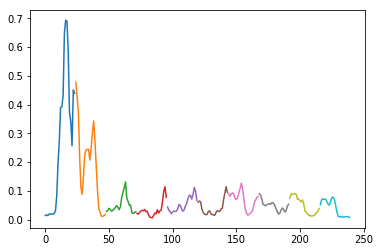

In [17]:
for i in range(10):
    plt.plot(wind_time["1"][i*24:24*(i+1)])
plt.show()

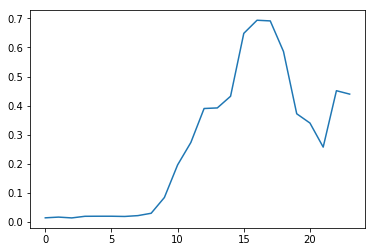

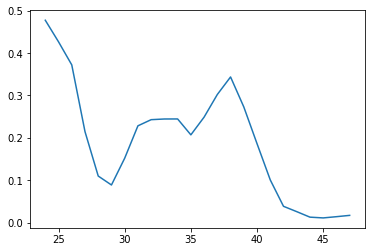

In [20]:
for i in range(2):
    plt.plot(wind_time["1"][i*24:24*(i+1)])
    plt.show()

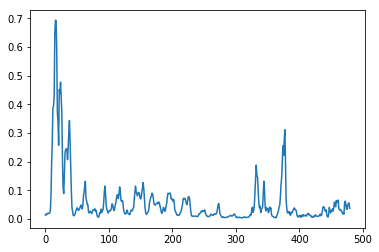

In [21]:
plt.plot(wind_time["1"][0:24*20])
plt.show()

1.271289030865916
0.8304324475837874
0.12758800884095653
0.06347810646199208
0.05748965124263669
0.11788553770501284
0.08608757169301502
0.037173781082908426
0.06347983931926734
0.15486503801697787


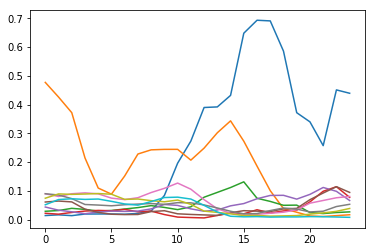

In [22]:
for i in range(10):
    d1 = np.array(wind_time["1"][i*24:24*(i+1)])
    d2 = np.array(wind_time["1"][(i+1)*24:(i+2)*24])
    print(DTWDistance(d1, d2,"numpy"))
    plt.plot(d1)
plt.show()

In [24]:
description = pd.read_csv("Static_data/generator_info.csv")

In [25]:
description.head(3)

,ID,name,country,origin,latitude,longitude,status,primaryfuel,secondaryfuel,capacity,lincost,cyclecost,minuptime,mindowntime,minonlinecapacity
0,2069,Almaraz Nuclear Power Plant Spain,Spain,162,39.807053,-5.69860,No Data in GEO,Nuclear,Unknown,1957.0,12.464831,587100.00,24,24,391.40
1,2142,Aramon Oil Power Plant France,France,486,43.880078,4.65477,Operating Fully,Fuel Oil,Unknown,1400.0,123.113578,77000.00,2,4,560.00
2,2154,Argentat Hydroelectric Generating Station,France,457,45.104000,1.95400,No Data in GEO,Hydro,Unknown,47.5,6.699853,204.25,0,0,4.75


In [30]:
import networkx as nx
RE_netwrok = nx.Graph()

In [31]:
for node in nodes.ID:
    RE_netwrok.add_node(node)
for i, row in edges.iterrows():
    RE_netwrok.add_edge(int(row.fromNode), int(row.toNode)) 

In [32]:
adj = nx.to_numpy_array(RE_netwrok)

consensus_matrix = consensus(adj, wind_time.iloc[:24*10, :], 20, method=0, data_format="pandas", show=True)

0


In [33]:
import seaborn as sns

In [34]:
new = consensus_matrix

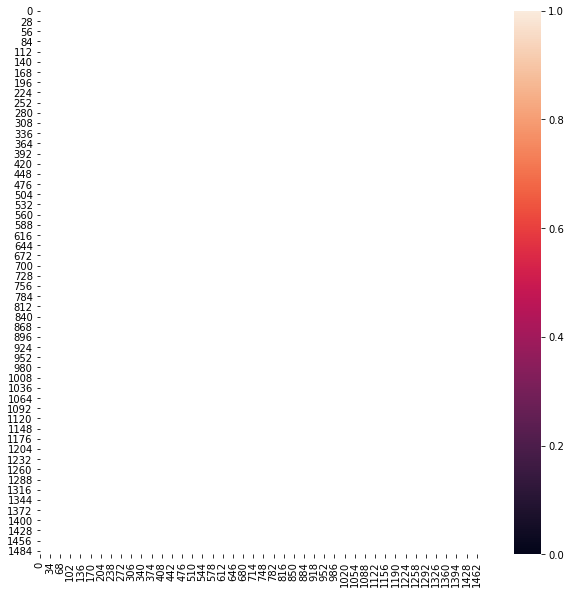

In [35]:
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(new, linewidth=1)
plt.show()

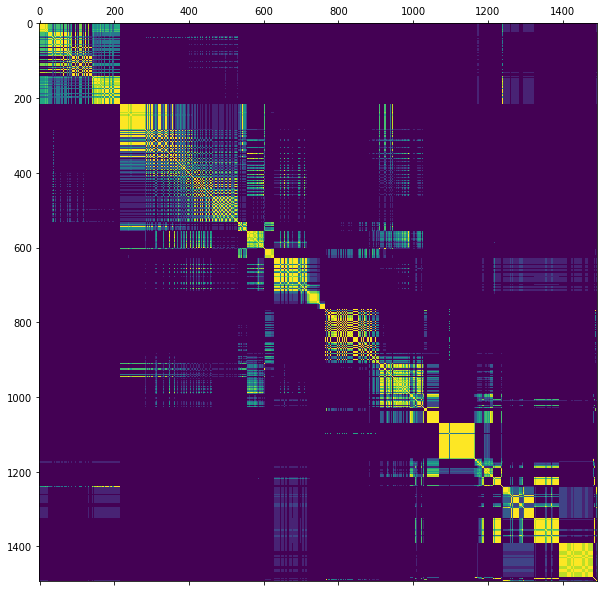

In [71]:
# new[new==0.0]=np.nan
# new = 1 - new
plt.figure(figsize=(10,10))
plt.matshow(new,aspect='auto', fignum=1)

In [37]:
clstr = KMeans(n_clusters=20)

In [60]:
consensus_matrix[consensus_matrix == np.nan]

array([], dtype=float64)

In [67]:
 consensus_matrix = np.nan_to_num(consensus_matrix)

In [66]:
consensus_matrix

array([[1. , 1. , 1. , ..., nan, nan, nan],
       [1. , 1. , 1. , ..., nan, nan, nan],
       [1. , 1. , 1. , ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 1. , 0.2, nan],
       [nan, nan, nan, ..., 0.2, 1. , nan],
       [nan, nan, nan, ..., nan, nan, 1. ]])

In [38]:
predictions = clstr.fit_predict(consensus_matrix)

In [20]:
DTWDistance(solar_time.iloc[24:48,1], solar_time.iloc[24:48,1000])

1.065720835866504

In [63]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import plotly.plotly as py
import colorlover as cl

init_notebook_mode(connected=True)

In [64]:
net = RE_netwrok

In [65]:
pos = nx.spring_layout(net)
for key in pos.keys():
    net.node[key]['pos'] = pos[key]

dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

In [66]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in net.edges():
    x0, y0 = net.node[edge[0]]['pos']
    x1, y1 = net.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in net.nodes():
    x, y = net.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [67]:
for node, adjacencies in enumerate(net.adjacency()):
    node_trace['marker']['color']+=tuple([predictions[node]])
    node_info = 'cluster: '+str(predictions[node]) + " node: " + str(node)
    node_trace['text']+=tuple([node_info]) 

In [68]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>RE dataset',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

In [55]:
np.savetxt("clusters.csv", predictions, delimiter=",")

In [73]:
consensus_matrix.shape

(1494, 1494)